In [1]:
from google.colab import files
uploaded = files.upload()

Saving Divvy Time Series Dataset - Sheet1.csv to Divvy Time Series Dataset - Sheet1.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from prophet import Prophet
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df = pd.read_csv('Divvy Time Series Dataset - Sheet1.csv')
df.head(5)

,Year,Month,Total Counts,Classic Bike Count,Electric Bike Count,Docked Bike Count,Electric Scooter Count,Casual User Count,Member User Count
0,2020.0,4,84776,NaN,NaN,84776.0,NaN,23628,61148
1,NaN,5,200274,NaN,NaN,200274.0,NaN,86909,113365
2,NaN,6,343005,NaN,NaN,343005.0,NaN,154718,188287
3,NaN,7,551480,NaN,1935.0,549545.0,NaN,269296,282184
4,NaN,8,622361,NaN,66195.0,556166.0,NaN,289661,332700


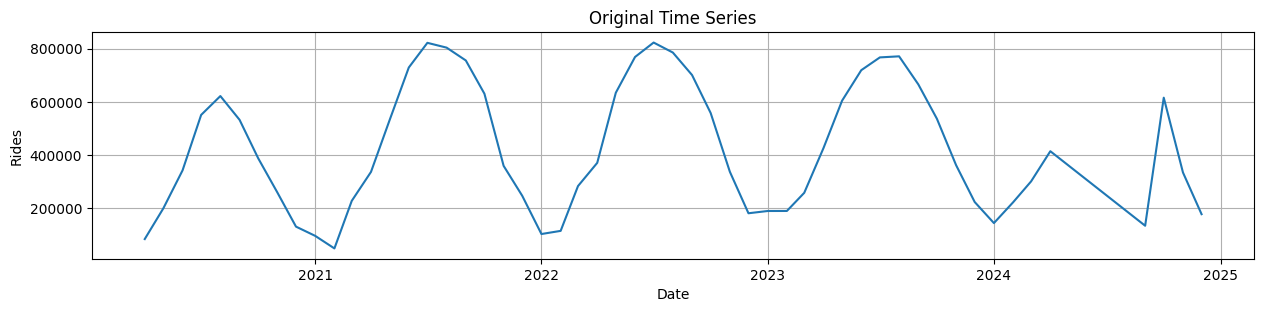

In [26]:
# Prepare data
df['Year'] = df['Year'].ffill()
df['date'] = pd.to_datetime(df.apply(lambda x: f"{int(x['Year'])}-{int(x['Month'])}-01", axis=1))

# Create time series
ts_df = pd.DataFrame({
    'date': df['date'],
    'rides': df['Total Counts']
}).set_index('date')

# Remove summer 2024 months
ts_df = ts_df[~((ts_df.index.year == 2024) & (ts_df.index.month.isin([5, 6, 7, 8])))]

def run_stationarity_tests(series, title):
    """Run ADF and KPSS tests and print results"""
    print(f"\n=== Stationarity Tests for {title} ===")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print("\nAugmented Dickey-Fuller Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.4f}")

    # KPSS Test
    kpss_result = kpss(series.dropna(), regression='c', nlags="auto")
    print("\nKPSS Test:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.4f}")

# Original Series Analysis
plt.figure(figsize=(15, 10))

# Plot original series
plt.subplot(311)
plt.plot(ts_df.index, ts_df['rides'])
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Rides')
plt.grid(True)

In [29]:
# Run stationarity tests
run_stationarity_tests(ts_df['rides'], "Original Series")


=== Stationarity Tests for Original Series ===

Augmented Dickey-Fuller Test:
ADF Statistic: -5.8595
p-value: 0.0000
Critical values:
	1%: -3.5715
	5%: -2.9226
	10%: -2.5993

KPSS Test:
KPSS Statistic: 0.0690
p-value: 0.1000
Critical values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390


<ipython-input-26-53740af2b929>:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c', nlags="auto")


=== Original Series ===

Significant ACF lags:
Lag 1: 0.766
Lag 2: 0.448
Lag 4: -0.363
Lag 5: -0.620
Lag 6: -0.689
Lag 7: -0.562
Lag 8: -0.290
Lag 10: 0.359
Lag 11: 0.550
Lag 12: 0.589
Lag 13: 0.463
Lag 16: -0.334
Lag 17: -0.480
Lag 18: -0.501
Lag 19: -0.380
Lag 23: 0.318
Lag 24: 0.314

Significant PACF lags:
Lag 1: 0.781
Lag 2: -0.370
Lag 3: -0.470
Lag 4: -0.508
Lag 22: -0.272

=== Seasonal Difference (lag=3) ===

Significant ACF lags:
Lag 1: 0.790
Lag 2: 0.440
Lag 4: -0.486
Lag 5: -0.775
Lag 6: -0.840
Lag 7: -0.681
Lag 8: -0.338
Lag 10: 0.453
Lag 11: 0.688
Lag 12: 0.732
Lag 13: 0.572
Lag 16: -0.406
Lag 17: -0.584
Lag 18: -0.595
Lag 19: -0.434
Lag 22: 0.337
Lag 23: 0.456
Lag 24: 0.432

Significant PACF lags:
Lag 1: 0.806
Lag 2: -0.545
Lag 3: -0.785
Lag 4: -0.460
Lag 5: -0.312
Lag 6: -0.522
Lag 7: -0.863
Lag 8: -3.998
Lag 9: 1.311
Lag 10: 0.625
Lag 11: 0.549
Lag 12: 0.697
Lag 13: 1.503
Lag 14: -2.582
Lag 15: -0.727
Lag 16: -0.508
Lag 17: -0.356
Lag 21: -0.473
Lag 22: -0.782
Lag 23: -2.

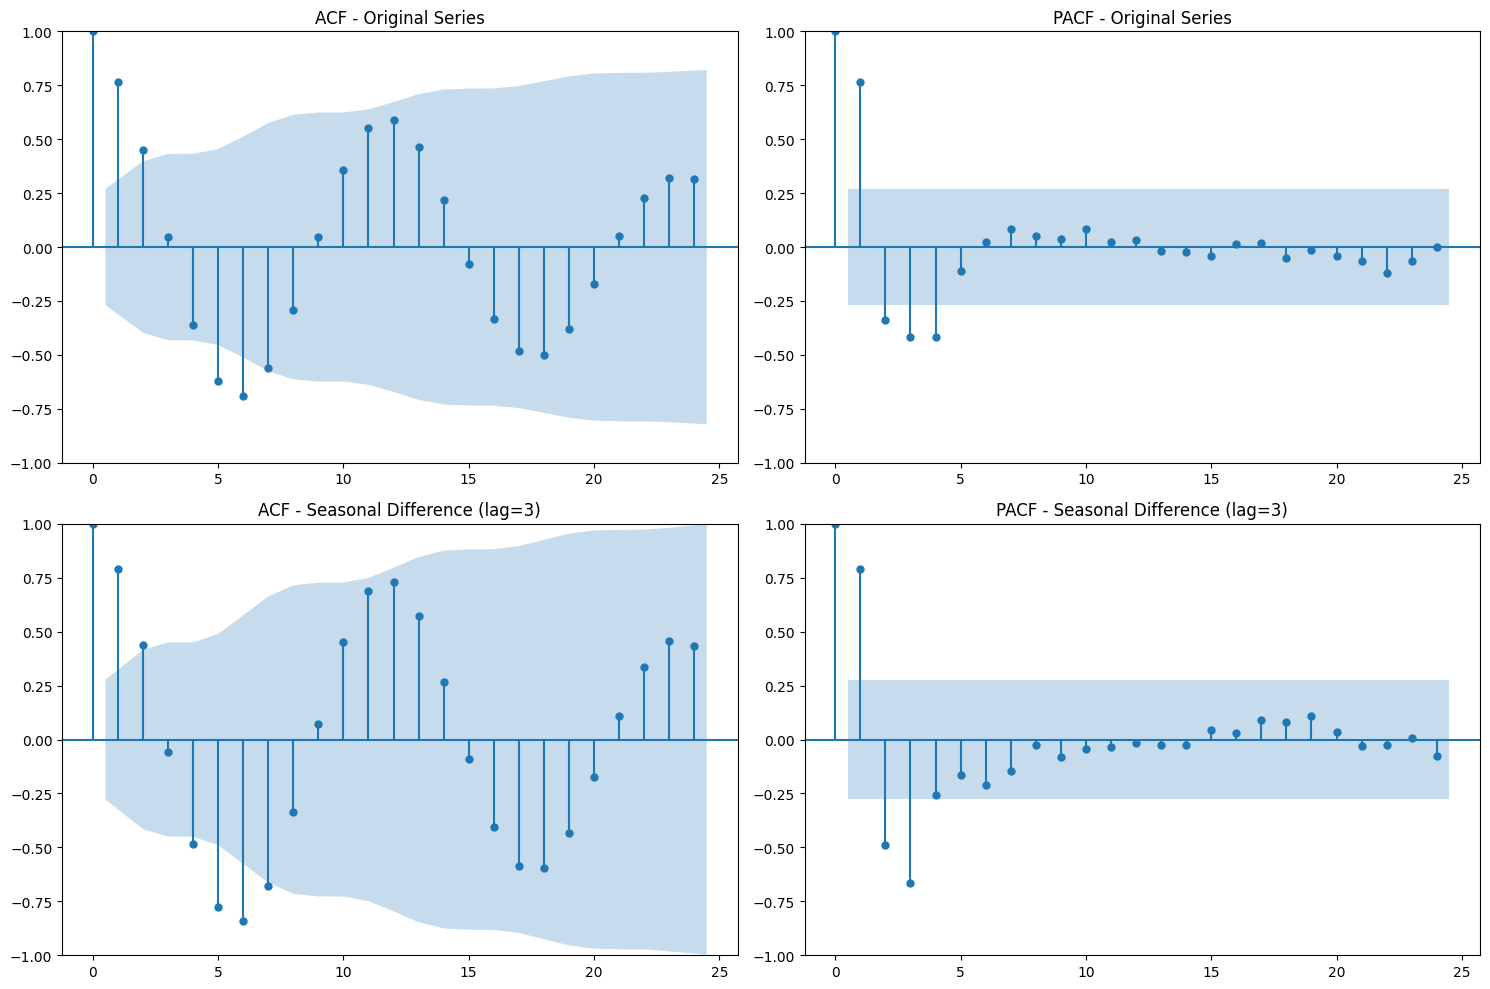

In [31]:
# Create figure for ACF and PACF plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Regular ACF and PACF
plot_acf(ts_df['rides'], lags=24, ax=ax1, title='ACF - Original Series')
plot_pacf(ts_df['rides'], lags=24, ax=ax2, title='PACF - Original Series')

# Calculate and plot seasonal ACF/PACF (lag 3 for quarterly seasonality)
seasonal_data = ts_df['rides'].diff(3).dropna()
plot_acf(seasonal_data, lags=24, ax=ax3, title='ACF - Seasonal Difference (lag=3)')
plot_pacf(seasonal_data, lags=24, ax=ax4, title='PACF - Seasonal Difference (lag=3)')

plt.tight_layout()

# Print significant lags
def print_significant_lags(series, alpha=0.05):
    acf_vals = acf(series, nlags=24)
    pacf_vals = pacf(series, nlags=24)

    # Calculate confidence intervals
    conf_int = 1.96/np.sqrt(len(series))

    print("\nSignificant ACF lags:")
    for i, val in enumerate(acf_vals):
        if abs(val) > conf_int and i > 0:  # Skip lag 0
            print(f"Lag {i}: {val:.3f}")

    print("\nSignificant PACF lags:")
    for i, val in enumerate(pacf_vals):
        if abs(val) > conf_int and i > 0:  # Skip lag 0
            print(f"Lag {i}: {val:.3f}")

print("=== Original Series ===")
print_significant_lags(ts_df['rides'])

print("\n=== Seasonal Difference (lag=3) ===")
print_significant_lags(seasonal_data)

In [33]:
# Fit SARIMA model based on ACF/PACF analysis
model = SARIMAX(ts_df['rides'],
                order=(2, 0, 1),           # (p,d,q) from ACF/PACF analysis
                seasonal_order=(1, 0, 1, 3),  # (P,D,Q,s) quarterly seasonality
                enforce_stationarity=True)

results = model.fit()

# Get predictions and confidence intervals
predictions = results.get_prediction(start=ts_df.index[0])
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Calculate metrics
actual = ts_df['rides']
predicted = predicted_mean
residuals = actual - predicted

# Print model summary
print("=" * 50)
print("SARIMA(2,0,1)(1,0,1,3) MODEL SUMMARY")
print("=" * 50)

print("\nModel Parameters:")
print(results.summary().tables[1].as_text())

print("\nModel Information Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"HQIC: {results.hqic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA(2,0,1)(1,0,1,3) MODEL SUMMARY

Model Parameters:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0596      0.336     -0.177      0.859      -0.718       0.599
ar.L2          0.8935      0.269      3.328      0.001       0.367       1.420
ma.L1          0.7944      0.273      2.907      0.004       0.259       1.330
ar.S.L3       -0.2492      0.269     -0.928      0.353      -0.776       0.277
ma.S.L3        0.9660      0.503      1.920      0.055      -0.020       1.952
sigma2      1.865e+10   4.69e-11   3.98e+20      0.000    1.87e+10    1.87e+10

Model Information Criteria:
AIC: 1416.86
BIC: 1428.68
HQIC: 1421.41

Performance Metrics:
R-squared (R²): 0.679
Mean Absolute Error (MAE): 114,691.02
Root Mean Squared Error (RMSE): 135,078.59
Mean Absolute Percentage Error (MAPE): 39.77%


In [34]:
# Add seasonal indicators
ts_df['month'] = ts_df.index.month
ts_df['season'] = pd.cut(ts_df['month'],
                        bins=[0, 3, 6, 9, 12],
                        labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Create seasonal dummies
seasonal_dummies = pd.get_dummies(ts_df['season'], prefix='season')
ts_df = pd.concat([ts_df, seasonal_dummies], axis=1)

# Fit improved SARIMA model
# Simplified model with external regressors for seasonality
model = SARIMAX(ts_df['rides'],
                order=(1, 0, 1),           # Simplified ARIMA order
                seasonal_order=(1, 0, 1, 3),  # Keep quarterly seasonality
                exog=seasonal_dummies,     # Add seasonal dummies
                enforce_stationarity=True)

results = model.fit()

# Get predictions
predictions = results.get_prediction(start=ts_df.index[0], exog=seasonal_dummies)
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Calculate metrics
actual = ts_df['rides']
predicted = predicted_mean
residuals = actual - predicted

# Print model summary
print("=" * 50)
print("IMPROVED SARIMA MODEL SUMMARY")
print("=" * 50)

print("\nModel Parameters:")
print(results.summary().tables[1].as_text())

print("\nModel Information Criteria:")
print(f"AIC: {results.aic:.2f}")
print(f"BIC: {results.bic:.2f}")
print(f"HQIC: {results.hqic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")


IMPROVED SARIMA MODEL SUMMARY

Model Parameters:
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
season_Winter  1.823e+05   9.11e+04      2.000      0.045    3667.254    3.61e+05
season_Spring  4.745e+05   7.22e+04      6.570      0.000    3.33e+05    6.16e+05
season_Summer  6.724e+05    8.3e+04      8.098      0.000     5.1e+05    8.35e+05
season_Fall    3.567e+05   8.58e+04      4.157      0.000    1.89e+05    5.25e+05
ar.L1             0.6369      1.142      0.558      0.577      -1.602       2.876
ma.L1            -0.4570      1.235     -0.370      0.711      -2.877       1.963
ar.S.L3          -0.3277      0.623     -0.526      0.599      -1.549       0.893
ma.S.L3           0.8832      0.618      1.428      0.153      -0.329       2.095
sigma2         2.268e+10      0.374   6.06e+10      0.000    2.27e+10    2.27e+10

Model Information Criteria:
AIC: 1425.34
BIC: 14

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# **Prophet Model**

In [41]:
# Create prophet dataframe
prophet_df = pd.DataFrame({
    'ds': df['date'],
    'y': df['Total Counts']
})

# Remove summer 2024 months
prophet_df = prophet_df[~((prophet_df['ds'].dt.year == 2024) &
                         (prophet_df['ds'].dt.month.isin([5, 6, 7, 8])))]

# Create and fit Prophet model
model = Prophet(
    seasonality_mode='multiplicative',  # Multiplicative seasonality for varying amplitude
    yearly_seasonality=True,
    weekly_seasonality=False,  # No weekly seasonality as we have monthly data
    daily_seasonality=False    # No daily seasonality as we have monthly data
)

model.fit(prophet_df)

# Make predictions
forecast = model.predict(prophet_df)

# Calculate metrics
actual = prophet_df['y'].values
predicted = forecast['yhat'].values
residuals = actual - predicted
n = len(actual)

# Calculate number of parameters
# Prophet components: trend (2 params), yearly seasonality (20 params by default)
k = 22  # 2 + 20

# Calculate log-likelihood (assuming Gaussian errors)
sigma2 = np.sum(residuals**2) / n
log_likelihood = -n/2 * np.log(2*np.pi*sigma2) - np.sum(residuals**2)/(2*sigma2)

# Calculate AIC and BIC
aic = -2 * log_likelihood + 2 * k
bic = -2 * log_likelihood + np.log(n) * k

print("=" * 50)
print("PROPHET MODEL METRICS")
print("=" * 50)

print("\nInformation Criteria:")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

print("\nPerformance Metrics:")
print(f"R-squared (R²): {r2_score(actual, predicted):.3f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(actual, predicted):,.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(actual, predicted)):,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(np.abs((actual - predicted) / actual)) * 100:.2f}%")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vt6xo5m/kv78ymxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6vt6xo5m/85rv2xq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=723', 'data', 'file=/tmp/tmp6vt6xo5m/kv78ymxk.json', 'init=/tmp/tmp6vt6xo5m/85rv2xq7.json', 'output', 'file=/tmp/tmp6vt6xo5m/prophet_modelrbiqglzb/prophet_model-20250218232415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:24:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


PROPHET MODEL METRICS

Information Criteria:
AIC: 1394.90
BIC: 1438.24

Performance Metrics:
R-squared (R²): 0.879
Mean Absolute Error (MAE): 54,278.84
Root Mean Squared Error (RMSE): 82,899.38
Mean Absolute Percentage Error (MAPE): 22.81%


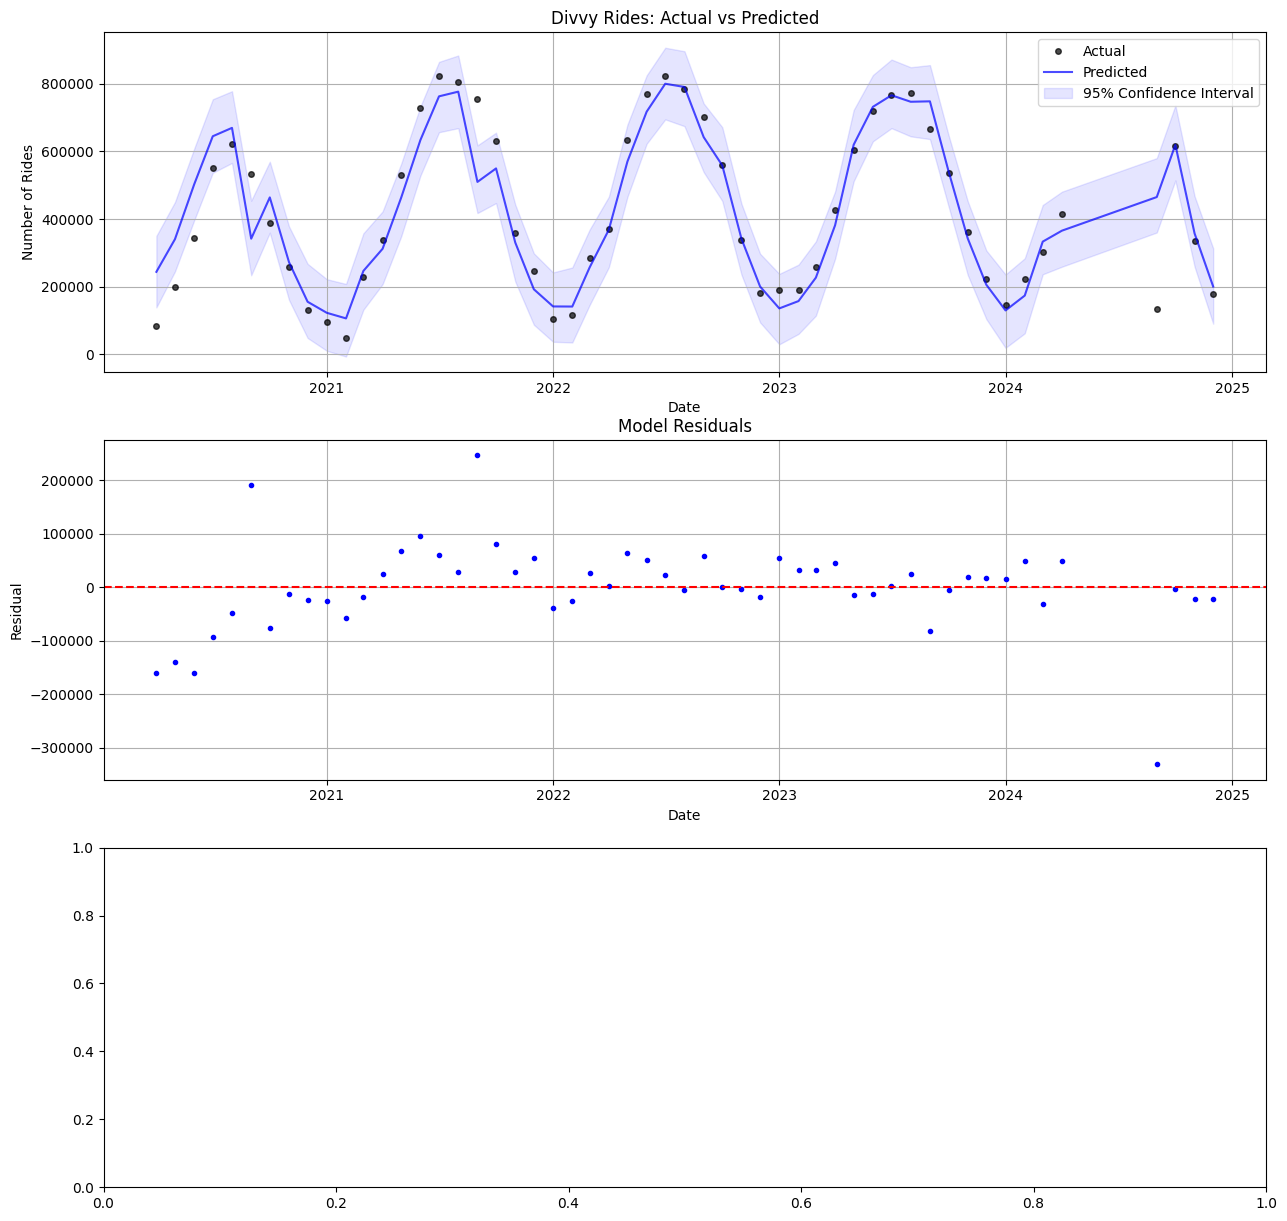

In [38]:
# Plot the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# Actual vs Predicted
ax1.plot(prophet_df['ds'], actual, 'ko', label='Actual', alpha=0.7, markersize=4)
ax1.plot(prophet_df['ds'], predicted, 'b-', label='Predicted', alpha=0.7)
ax1.fill_between(prophet_df['ds'],
                 forecast['yhat_lower'],
                 forecast['yhat_upper'],
                 color='b', alpha=0.1, label='95% Confidence Interval')
ax1.set_title('Divvy Rides: Actual vs Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Rides')
ax1.legend()
ax1.grid(True)

# Residuals
ax2.plot(prophet_df['ds'], residuals, 'b.')
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Model Residuals')
ax2.set_xlabel('Date')
ax2.set_ylabel('Residual')
ax2.grid(True)


Component Analysis:
--------------------
Overall Trend Growth: 51.2%

Yearly Seasonality Statistics:
Mean: -0.07
Std Dev: 0.49
Min: -0.74
Max: 0.85


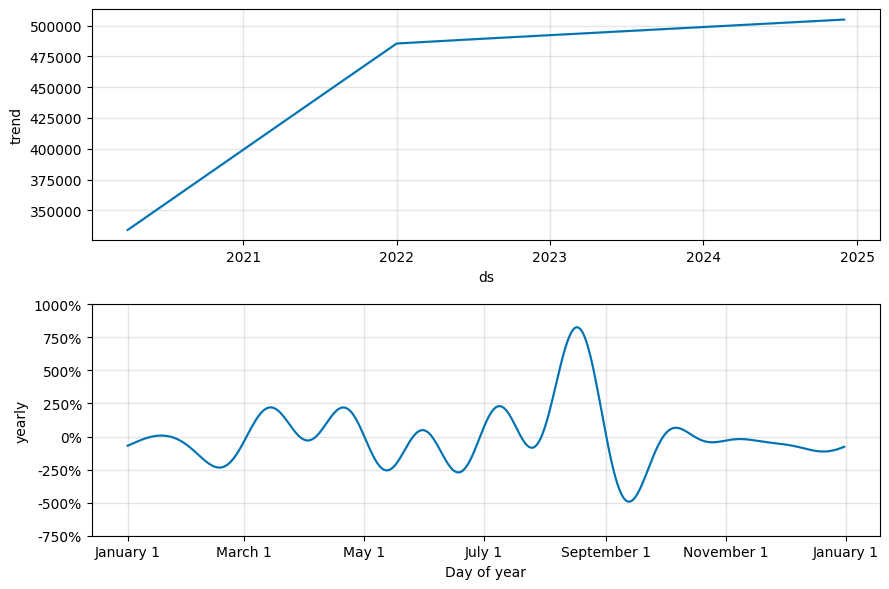

In [43]:
# Components
model.plot_components(forecast)
plt.tight_layout()

# Additional Analysis
print("\nComponent Analysis:")
print("-" * 20)
trend_growth = (forecast['trend'].iloc[-1] - forecast['trend'].iloc[0]) / forecast['trend'].iloc[0] * 100
print(f"Overall Trend Growth: {trend_growth:.1f}%")

seasonal_stats = forecast['yearly'].describe()
print("\nYearly Seasonality Statistics:")
print(f"Mean: {seasonal_stats['mean']:.2f}")
print(f"Std Dev: {seasonal_stats['std']:.2f}")
print(f"Min: {seasonal_stats['min']:.2f}")
print(f"Max: {seasonal_stats['max']:.2f}")

The Prophet model performs better than the ARIMA models, with strong predictive accuracy (R² = 0.879) and reasonable error metrics (MAPE = 22.81%). Looking at the plots, it captures the seasonal patterns effectively, but there are some notable residuals, particularly in early 2021 and late 2024. The model could potentially be improved by adding change points around significant pattern shifts, adjusting the seasonality parameters to better capture the varying amplitudes in summer peaks, or incorporating additional regressors like weather data or special events that might affect ridership. The lower AIC (1394.90) compared to our previous SARIMA model suggests better model fit, though the residual plot indicates there might still be some unmodeled patterns in the data.